# TreeModel

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('dark_background')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [90]:
items = pd.read_csv("../data/input/items.csv")
item_categories = pd.read_csv("../data/input/item_categories.csv")
shops = pd.read_csv("../data/input/shops.csv")
train = pd.read_csv("../data/input/sales_train.csv.gz")
test = pd.read_csv("../data/input/test.csv.gz")
sample_predict = pd.read_csv("../data/input/sample_submission.csv.gz")

In [3]:
train_s = pd.merge(train, shops, on="shop_id", sort=False)
train_si = pd.merge(train_s, items, on="item_id", sort=False)
train_siic = pd.merge(train_si, item_categories, on="item_category_id", sort=False)


In [4]:
display(train_siic.head())
display(test.head())

# とりあえず shop_id, item_id だけで試す
train_sample = train_siic[['shop_id', 'item_id', 'item_cnt_day']]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [35]:
# 特定の shop_id, item_id の 一ヶ月での売上を予測する必要がある 
# モデル自体が一ヶ月の売上を出力するようにする必要がある
test.head()

# uniquer shop_id ,item_id set
np.unique(test.groupby(['shop_id', 'item_id']).count().reset_index()['ID'].values)

# シンプルに一ヶ月でデータをサマル
feature_columns = ['date_block_num','shop_id', 'item_id']
feature_and_target_columns = feature_columns.copy()
feature_and_target_columns.append("item_cnt_month")
train_per_month = train.groupby(['date_block_num','shop_id', 'item_id']).sum()
train_per_month = train_per_month.reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})[feature_and_target_columns]


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


array([1])

# ツリーモデルを用いた回帰を行ってみる

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [39]:
regressor = RandomForestRegressor()
cross_val_score(
    regressor,
    train_per_month[feature_columns].values,
    train_per_month.item_cnt_month,
    scoring="neg_mean_squared_error",
    cv=5
)

/Users/a_shika/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/a_shika/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/a_shika/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/a_shika/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "

array([ -28.03000991,  -40.45058199,  -30.40791483,  -56.7771542 ,
       -107.30527555])

In [51]:
forest = RandomForestRegressor()
forest.fit(train_per_month[feature_columns].values, train_per_month.item_cnt_month)

/Users/a_shika/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [52]:
test_extend_feature = test.copy()
test_extend_feature['date_block_num'] = train['date_block_num'].max()+1
# 学習データと同じ順番に特徴量を並び替え
test_extend_feature = test_extend_feature[feature_columns]

In [67]:
pred = forest.predict(test_extend_feature)

# 値の範囲は 0~20 と決まっているので制限する
pred[np.where(pred<0)] = 0
pred[np.where(pred>20)] = 20

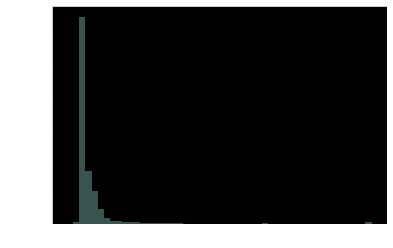

In [68]:
sns.distplot(pred, kde=False)

In [94]:
# create submission csv

# pd.read_csv('../data/input/sample_submission.csv.gz')

submision = pd.DataFrame(test['ID'])
submision['item_cnt_month'] = pred
submision.head()

,ID,item_cnt_month
0,0,1.2
1,1,2.4
2,2,1.2
3,3,1.1
4,4,1.0


In [97]:

submision.to_csv("../data/output/submission.csv",index=False, header=True)